In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib
from matplotlib import cm
import json

import seaborn as sns

from datetime import datetime, timedelta 

from sklearn.linear_model import LinearRegression, Lasso

ID = 'PROD'
SYMBOL = 'SIMUl'

sns.set_context("paper")
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 14

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import time
import plotly.graph_objects as go

cmap = matplotlib.cm.get_cmap('viridis')

In [277]:
path_zi = "ZI"
path_ft = "ZI_FT"
path = "ZI_FT_MT"

with open(path_ft + '/sim_params.json'.format(ID)) as f:
    sim_params = json.load(f)
    
n_runs = 1
sim_params

{'reference_prc': 125.24,
 'closing_bid_prc': 125.22,
 'closing_ask_prc': 125.26,
 'tick_size': 0.02,
 'l2_depth': 10,
 'symbol': 'ZIl',
 'tick_format': 'LSE',
 'date_format': '%d-%b-%Y %H:%M:%S',
 'n_runs': 100,
 'n_zi_traders': 100,
 'n_ft_traders': 50,
 'n_mt_traders': 0}

In [266]:
from joblib import Parallel, delayed

def run_task(k, tick_size=.02, with_l3=False, global_path=path_zi):
    simulation_id = f'run_{str(k).zfill(5)}'
    path = f'{global_path}/Results/{simulation_id}'
    df_lob_l1 = pd.read_csv(f'{path}/lob_l1.csv').set_index('time')
    df_lob_l1.index = pd.to_datetime(df_lob_l1.index)

    l1B = df_lob_l1[df_lob_l1['side']  == 'B']
    l1S = df_lob_l1[df_lob_l1['side']  == 'S']
    
    mp = .5 * l1B['prc'] + .5 * l1S['prc']
    spread = l1S['prc'] - l1B['prc']
    spread = np.round(spread.fillna(method='ffill').fillna(method='bfill') / tick_size).dropna().astype(int)
    
    orders = pd.read_csv(f'{path}/orders.csv').set_index('time')
    orders.index = pd.to_datetime(orders.index)
    
    b0 = l1B['prc'].shift(1)
    a0 = l1S['prc'].shift(1)
    depth_b = np.round((b0.reindex(orders.index) - orders['prc']) / tick_size)
    depth_a = np.round((orders['prc'] - a0.reindex(orders.index)) / tick_size)

    orders.loc[:,'depth'] = ((orders['side'] == 'B') * depth_b + (orders['side'] == 'S') * depth_a).values
    
    trades = pd.read_csv(f'{path}/trades.csv').set_index('time')
    trades.index = pd.to_datetime(trades.index)
    
    return [l1B, l1S, mp, spread, orders, trades]


ii = np.arange(10)
res = Parallel(n_jobs=6, verbose=8)(delayed(run_task)(i, with_l3=False, 
                                                      global_path=path_ft) for i in ii)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:   19.2s remaining:   44.9s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:   19.6s remaining:   19.6s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:   33.2s remaining:   14.2s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   33.4s finished


In [267]:
l1B = {i : res[i][0] for i in ii}
l1S = {i : res[i][1] for i in ii}
mp = {i : res[i][2] for i in ii}
spread = {i : res[i][3] for i in ii}
orders = {i : res[i][4] for i in ii}
trades = {i : res[i][5] for i in ii}

### Checking $\alpha$, $\mu$, $\delta$ and the equilibrium LOB depth

In [10]:
mu = orders[0][(orders[0]['OrdType'] == 'M')].resample('20L').size().mean()
zi_mu = orders[0][(orders[0]['OrdType'] == 'M') & 
                  (orders[0]['TraderType'] == 'ZI')].resample('20L').size().mean()
alpha = orders[0][(orders[0]['OrdType'] == 'L')].resample('20L').size().mean()
delta = orders[0][(orders[0]['OrdType'] == 'C')].resample('20L').size().mean()

In [11]:
assert np.round(alpha, 2) == 0.02
assert np.round(zi_mu, 3) == 0.002

In [12]:
delta_ = orders[0][(orders[0]['OrdType'] == 'C') & (orders[0]['TraderType'] == 'ZI')].resample('20L').size()
depth = (l1B[0]['depth'] + l1S[0]['depth']).resample('20L').mean().ffill()
delta = (delta_ / depth[:delta_.shape[0]].values).mean()
assert np.round(delta, 4) == .0005

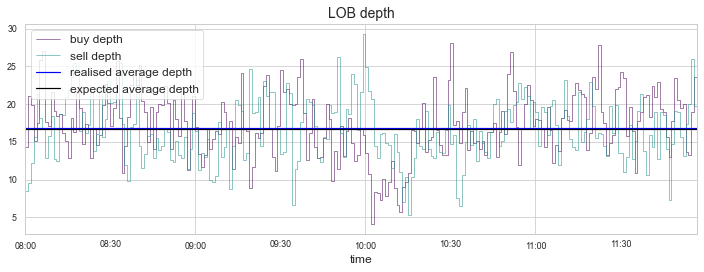

In [13]:
fg, ax = plt.subplots(1, 1, figsize=(10, 4), squeeze=False)

for lob, color, label in [(l1B, cmap(0), 'buy'), (l1S, cmap(.5), 'sell')]:
    side_depth = lob[0]['depth'].resample('60S').mean()
    side_depth.plot(ax=ax[0][0], drawstyle='steps-post', lw=.5, color=color, label=label + " depth")

buy_depth = l1B[0]['depth'].resample('60S').mean()
sell_depth = l1S[0]['depth'].resample('60S').mean()
pd.Series(np.ones(buy_depth.shape[0]) * (buy_depth + sell_depth).mean() / 2, index=buy_depth.index).plot(
    ax=ax[0][0], color='b', label='realised average depth')
pd.Series(
    np.ones(buy_depth.shape[0]) * (alpha - mu) / (2 * delta), index=buy_depth.index).plot(
    ax=ax[0][0], color='k', label = 'expected average depth')

ax[0][0].set_title('LOB depth', fontsize=14)
ax[0][0].legend(loc='upper left', fontsize=12)
ax[0][0].set_xlabel('time', fontsize=12)
fg.tight_layout()

### Distribution of depth of orders

Text(0.5, 1.0, 'Distribution of the depths of orders')

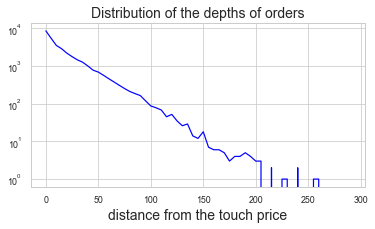

In [9]:
fg, ax = plt.subplots(1, 1, figsize=(6, 3))

h, bins = np.histogram(abs(orders[0][orders[0]['OrdType'] == 'L']['depth']), bins=np.arange(0, 300, 5))
pd.Series(h, index=bins[:-1]).plot(ax=ax, color='b')
ax.set_yscale('log')
ax.set_xlabel('distance from the touch price', fontsize=14)
ax.set_title('Distribution of the depths of orders', fontsize=14)


### Distribution of spreads

Text(0.5, 1.0, 'Distribution of spreads')

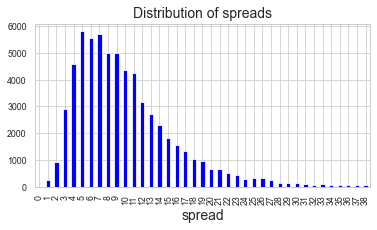

In [10]:
fg, ax = plt.subplots(1, 1, figsize=(6, 3))

h, bins = np.histogram(spread[0], bins=np.arange(0, 40))
pd.Series(h, index=bins[:-1]).plot.bar(ax=ax, color='b')
ax.set_xlabel('spread', fontsize=14)
ax.set_title('Distribution of spreads', fontsize=14)

### Distribution of duration of each limit order

In [11]:
def get_dt(x):
    try:
        return x.iloc[1]['t'] - x.iloc[0]['t'] 
    except:
        return np.NaN

deltaT = orders[0].groupby('order_id')[['t', 'OrdType']].apply(lambda x: get_dt(x)).dropna()

Text(0.5, 1.0, 'Distribution of time until cancellation')

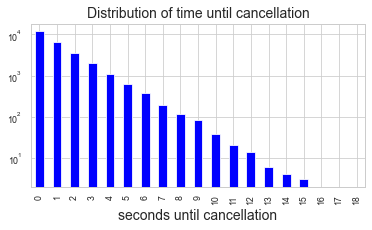

In [12]:
fg, ax = plt.subplots(1, 1, figsize=(6, 3))

h, bins = np.histogram(deltaT / 1000, bins=np.arange(20))
pd.Series(h, index=bins[:-1]).plot.bar(ax=ax, color='b')
ax.set_xlabel('seconds until cancellation', fontsize=14)
ax.set_yscale('log')
ax.set_title('Distribution of time until cancellation', fontsize=14)

### Single run stats

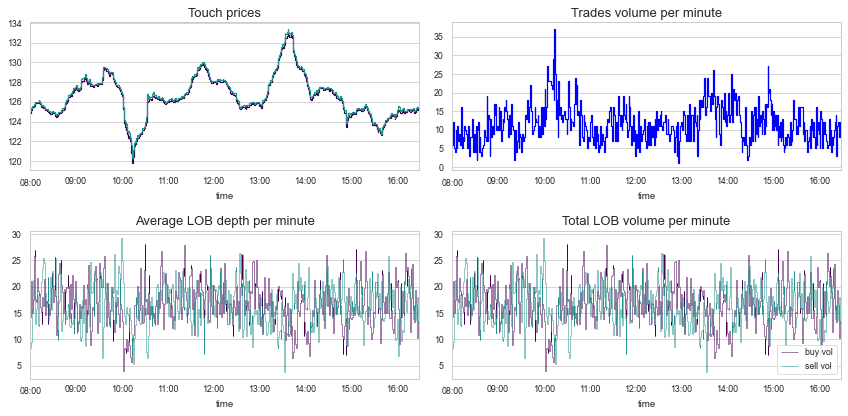

In [13]:
fg, ax = plt.subplots(2, 2, figsize=(12, 6))


dt = '60S'
a = l1S[0]['prc'].resample(dt).mean()
b = l1B[0]['prc'].resample(dt).mean()

ax[0][0].fill_between(a.index, a, b, color='gray', alpha=.1, step='post')

b.plot(ax=ax[0][0], grid=True, legend=False, color=cmap(0.), 
       drawstyle='steps-post', label='buy',)
a.plot(ax=ax[0][0], grid=True, legend=False, color=cmap(.5), 
       drawstyle='steps-post', label='sell')
ax[0][0].set_title('Touch prices', fontsize=13)


trades[0]['vol'].resample(dt).sum().plot(ax=ax[0][1], color='b', drawstyle='steps-post',)
ax[0][1].set_title('Trades volume per minute', fontsize=13)


for lob, color, label in [(l1B, cmap(0), 'buy'), (l1S, cmap(.5), 'sell')]:
    side_depth = lob[0]['depth'].resample(dt).mean()
    side_depth.plot(ax=ax[1][0], drawstyle='steps-post', lw=.5, color=color, label=label + " depth")
ax[1][0].set_title('Average LOB depth per minute', fontsize=13)


for lob, color, label in [(l1B, cmap(0), 'buy'), (l1S, cmap(.5), 'sell')]:
    side_vol = lob[0]['total_vol'].resample(dt).mean()
    side_vol.plot(ax=ax[1][1], drawstyle='steps-post', lw=.5, color=color, label=label + " vol")

ax[1][1].set_title('Total LOB volume per minute', fontsize=13)
ax[1][1].legend(loc='best')

fg.tight_layout()

### Hurst plot

In [16]:
def get_hurst(p, dtau):
    x = np.log(dtau)
    y = np.array([np.log(np.nanstd(p[int(lag):] - p[:-int(lag)])) for lag in dtau])
    return (y[1:] - y[:-1]) / (x[1:] - x[:-1])

In [17]:
def get_touch_prices(k, tick_size=.02, with_l3=False, global_path=path):
    simulation_id = f'run_{str(k).zfill(5)}'
    path = f'/Results/{simulation_id}'
    df_lob_l1 = pd.read_csv(f'{global_path}{path}/lob_l1.csv').set_index('time')
    df_lob_l1.index = pd.to_datetime(df_lob_l1.index)

    l1B = df_lob_l1[df_lob_l1['side']  == 'B']
    l1S = df_lob_l1[df_lob_l1['side']  == 'S']
    
    return {"buy price" : l1B['prc'], 
            "sell price" : l1S['prc']
           }

n_runs = 10
ii = np.arange(n_runs)
res = Parallel(n_jobs=6, verbose=8)(delayed(get_touch_prices)(i, with_l3=False, global_path=path_ft) for i in ii)
mp = {i : res[i] for i in ii}

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    8.8s remaining:   20.6s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:   14.7s remaining:    6.3s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   14.8s finished


In [18]:
dtau = np.unique(np.logspace(0, 2.5, 100, dtype=int))
h_list_buy = Parallel(n_jobs=6, verbose=8)(delayed(get_hurst)(
    mp[i]['buy price'].resample('10S').mean().ffill().values, dtau) for i in mp)
h_list_sell = Parallel(n_jobs=6, verbose=8)(delayed(get_hurst)(
    mp[i]['sell price'].resample('10S').mean().ffill().values, dtau) for i in mp)                 

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished


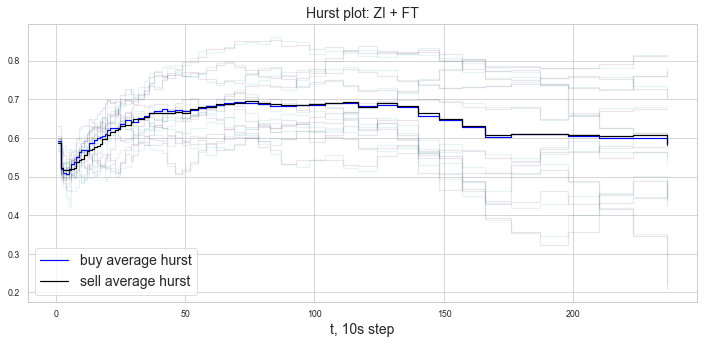

In [19]:
fg, ax = plt.subplots(1, 1, figsize=(10, 5))

idx = np.argwhere(dtau < 250).shape[0]
for hb in h_list_buy:
    pd.Series(hb[:idx], index=dtau[:idx]).plot(ax=ax, color=cmap(0), alpha=.1, 
                                               drawstyle='steps-post', label='_nolegend_')
    
pd.Series(np.mean(h_list_buy, axis=0)[:idx], index=dtau[:idx]).plot(ax=ax, 
                                                                    color='b', 
                                                                    drawstyle='steps-post',
                                                                   label='buy average hurst')

for hs in h_list_sell:
    pd.Series(hs[:idx], index=dtau[:idx]).plot(ax=ax, color=cmap(.5), alpha=.1, 
                                               drawstyle='steps-post', label='_nolegend_')
    
pd.Series(np.mean(h_list_sell, axis=0)[:idx], index=dtau[:idx]).plot(ax=ax, 
                                                                    color='k', 
                                                                    drawstyle='steps-post',
                                                                   label='sell average hurst')

ax.set_xlabel('t, 10s step', fontsize=14)
ax.set_title("Hurst plot: ZI + FT", fontsize=14)
ax.legend(loc='best', fontsize=14)
fg.tight_layout()

## Returns vs Distortion

In [21]:
def get_fv(run_id, global_path):
    fv = pd.read_csv(
        f"{global_path}/Results/run_{str(run_id).zfill(5)}/fundamental_value.csv", header=None).dropna()
    fv = fv.rename(columns={0: "time"})
    fv = fv.set_index("time")
    fv = fv.rename(columns={1: "value"})
    fv.index = pd.to_datetime(fv.index)
    return fv.iloc[:-1]

In [183]:
def get_dp_dist(run_id, global_path, dt):
    fv = get_fv(run_id, global_path)
    distortion = trades[run_id][['prc']]
    fv = fv.reindex(distortion.index, method='ffill')
    distortion = distortion.join(fv, how="left")

    distortion = distortion.join(mp[run_id].rename("mp").reindex(
        distortion.index, method='ffill'), 
                             how="left")

    distortion['v-p'] = distortion["value"] - distortion["prc"]
    d = distortion.resample(dt).mean()
    d.dropna(inplace=True)
    return d

In [188]:
res = Parallel(n_jobs=-1, verbose=8)(delayed(
    get_dp_dist)(i, global_path=path_ft, dt='1S') for i in np.arange(10))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


In [198]:
d = pd.DataFrame(np.concatenate(([res[i][['mp', 'v-p']].values for i in range(10)])), 
                 columns=['mp', 'v-p'])

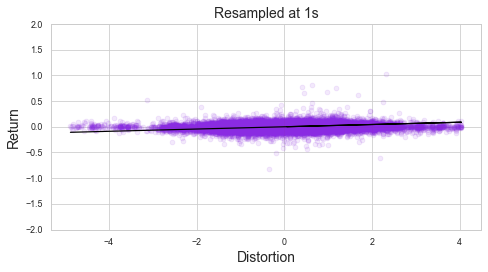

In [207]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
d_ = d[(d['v-p'] >= -1) & (d['v-p'] <= 1)]
lr.fit(d_['v-p'][:-1].values.reshape(-1, 1), d_['mp'].diff()[1:])

fg, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.scatter(d['v-p'][:-1], d['mp'].diff()[1:], color='blueviolet', alpha=.1)
ax.plot(d['v-p'][:-1], lr.coef_[0] * d['v-p'][:-1], color='k')

ax.set_xlabel('Distortion', fontsize=14)
ax.set_ylabel("Return", fontsize=14)
ax.set_ylim([-2, 2])
ax.set_title("Resampled at 1s", fontsize=14)
fg.tight_layout()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


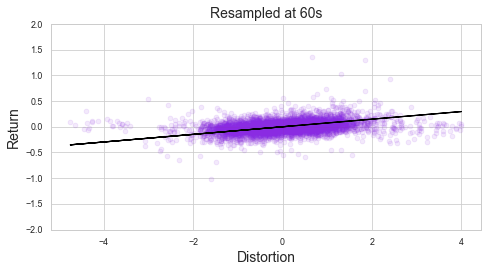

In [212]:
res = Parallel(n_jobs=-1, verbose=8)(delayed(
    get_dp_dist)(i, global_path=path_ft, dt='60S') for i in np.arange(10))

d = pd.DataFrame(np.concatenate(([res[i][['mp', 'v-p']].values for i in range(10)])), 
                 columns=['mp', 'v-p'])

lr = LinearRegression()
d_ = d[(d['v-p'] >= -2) & (d['v-p'] <= 2)]
lr.fit(d_['v-p'][:-1].values.reshape(-1, 1), d_['mp'].diff()[1:])

fg, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.scatter(d['v-p'][:-1], d['mp'].diff()[1:], color='blueviolet', alpha=.1)
ax.plot(d['v-p'][:-1], lr.coef_[0] * d['v-p'][:-1], color='k')

ax.set_xlabel('Distortion', fontsize=14)
ax.set_ylabel("Return", fontsize=14)
ax.set_ylim([-2, 2])
ax.set_title("Resampled at 60s", fontsize=14)
fg.tight_layout()

### Momentum vs Distortion

In [280]:
ii = np.arange(10)
res = Parallel(n_jobs=6, verbose=8)(delayed(run_task)(i, with_l3=False, 
                                                      global_path=path) for i in ii)

l1B = {i : res[i][0] for i in ii}
l1S = {i : res[i][1] for i in ii}
mp = {i : res[i][2] for i in ii}
spread = {i : res[i][3] for i in ii}
orders = {i : res[i][4] for i in ii}
trades = {i : res[i][5] for i in ii}

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:   18.4s remaining:   42.9s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:   18.6s remaining:   18.6s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:   30.9s remaining:   13.3s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   31.2s finished


In [480]:
def get_dp_momentum(run_id, alpha=.03, dt='1S'):
    M = 0
    t = trades[run_id].copy()
    t['momentum'] = 0
    t['momentum'] = t['momentum'].astype('double')
    t = t[t['buyer_id'].apply(lambda x: x[:2] == 'MT') |
             t['seller_id'].apply(lambda x: x[:2] == 'MT')]

    t = t.resample(dt).mean().dropna()
    for i in range(t.shape[0] - 1):
        M = alpha * (t['prc'].iloc[i + 1] - \
                    t['prc'].iloc[i]) + (1 - alpha) * M

        t.iat[i + 1, 3] = M

    m = mp[run_id]
    t = t.join(pd.DataFrame(m).rename(columns={'prc':'mprc'}).reindex(
        t.index, method="ffill"), how='left')
    return pd.DataFrame({"momentum" : t['momentum'][:-1],
                          "dp" : t['mprc'].diff()[1:]}).dropna()

In [517]:
res = Parallel(n_jobs=-1, verbose=8)(delayed(
    get_dp_momentum)(i, alpha=.02) for i in np.arange(10))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


In [505]:
d = pd.DataFrame(np.concatenate(([res[i][['momentum', 'dp']].values for i in range(10)])), 
                 columns=['momentum', 'dp'])

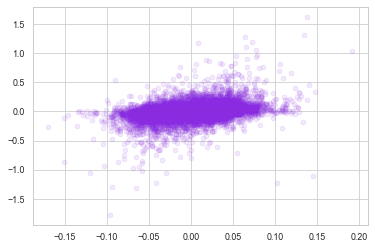

In [498]:
plt.scatter(d['momentum'], 
            d['dp'], color='blueviolet', alpha=.1)

In [507]:
res[0].shape[0] + res[1].shape[0]

2584

In [518]:
import GPy
kernel = GPy.kern.RBF(input_dim=1, variance=.1) + GPy.kern.White(input_dim=1, variance=100)

dim = res[0].shape[0] + res[1].shape[0]
gp = GPy.models.GPRegression(d['momentum'].values[:dim].reshape(-1, 1), 
                             d['dp'].values[:dim].reshape(-1, 1), kernel)
gp.optimize(messages=True, max_f_eval = 100)

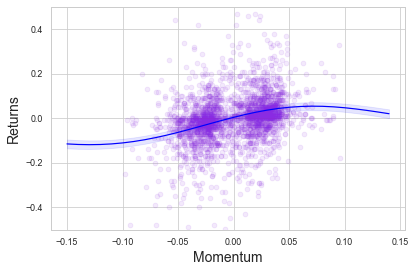

In [519]:
x_test = np.arange(-.15, .15, 0.01)
pred = gp.predict(x_test.reshape(-1, 1))

fg, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x_test, 
         pred[0].reshape(1, -1)[0], color='b', label='regression')
ax.fill_between(x_test, 
                pred[0].reshape(1, -1)[0] - pred[1].reshape(1, -1)[0], 
                pred[0].reshape(1, -1)[0] + pred[1].reshape(1, -1)[0], 
                color='b', alpha=.1)

ax.scatter(d['momentum'][:dim], 
            d['dp'][:dim], color='blueviolet', alpha=.1)
ax.set_ylim([-.5, .5])
ax.set_xlabel("Momentum", fontsize=14)
ax.set_ylabel("Returns", fontsize=14)

fg.tight_layout()

## single run testing

In [448]:
M = 0
ii = 3
trades[ii]['momentum'] = 0
trades[ii]['momentum'] = trades[ii]['momentum'].astype('double')
t = trades[ii][trades[ii]['buyer_id'].apply(lambda x: x[:2] == 'MT') |
         trades[ii]['seller_id'].apply(lambda x: x[:2] == 'MT')]

t = t.resample('1S').mean().dropna()
for i in range(t.shape[0] - 1):
    M = .03 * (t['prc'].iloc[i + 1] - \
                t['prc'].iloc[i]) + (1 - 0.03) * M
    
    t.iat[i + 1, 3] = M
    
m = mp[ii]
t = t.join(pd.DataFrame(m).rename(columns={'prc':'mprc'}).reindex(
    t.index, method="ffill"), how='left')

In [467]:
np.vstack((t['momentum'][:-1], 
            t['mprc'].diff()[1:]))

array([[ 0.        , -0.0144    , -0.015768  , ...,  0.01993979,
         0.01814159,  0.01699734],
       [-0.31      ,  0.06      , -0.42      , ..., -0.01      ,
        -0.06      , -0.02      ]])

In [401]:
1 / (0.05) * 1 / t.resample('1S').size().mean() / 60

9.551098376313275

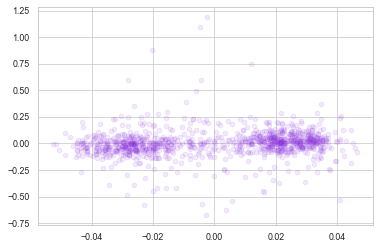

In [449]:
plt.scatter(t['momentum'][:-1], 
            t['mprc'].diff()[1:], color='blueviolet', alpha=.1)

In [454]:
import GPy
kernel = GPy.kern.RBF(input_dim=1, variance=.1) + GPy.kern.White(input_dim=1, variance=10)


gp = GPy.models.GPRegression(t['momentum'][:-1].values.reshape(-1, 1), 
                             t['mprc'].diff()[1:].values.reshape(-1, 1), kernel)
gp.optimize(messages=True, max_f_eval = 100)

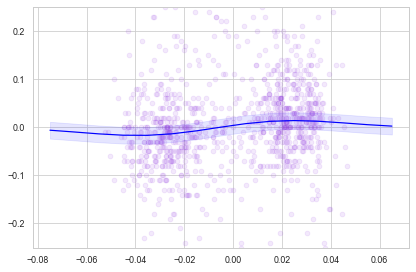

In [455]:
x_test = np.arange(-.075, .075, 0.01)
pred = gp.predict(x_test.reshape(-1, 1))

fg, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x_test, 
         pred[0].reshape(1, -1)[0], color='b', label='regression')
ax.fill_between(x_test, 
                pred[0].reshape(1, -1)[0] - pred[1].reshape(1, -1)[0], 
                pred[0].reshape(1, -1)[0] + pred[1].reshape(1, -1)[0], 
                color='b', alpha=.1)

ax.scatter(t['momentum'][:-1], 
            t['mprc'].diff()[1:], color='blueviolet', alpha=.1)
ax.set_ylim([-.25, .25])

fg.tight_layout()